# Ball Tree Nearest Neighbor

This is a work in progress implementation using the BallTree algoritm for the nearest neighbor search.

> **Why use BallTree instead of KDTree?**  
> Because `HaversineDistance64 is not valid for KDTree`


In [1]:
from herbie import Herbie
import herbie
from toolbox import EasyMap, pc, ccrs
from sklearn.neighbors import BallTree
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from pathlib import Path


import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

In [104]:
def nearest_neighbor(ds, points, *, how="nearest", use_cached_tree=True, verbose=False):
    """Find values at nearest neighbor locations.

    TODO: Get nearest neighbor or weighted mean of four nearest.
    TODO: Support BallTree for non-curvilinear grids so distance and weighted mean can be calculated

    **Note:** KDTree can't be used because it doesn't support the
    haversine minimization metric which is optimal for lat/lon
    distances.

    Parameters
    ----------
    ds : xarray.dataset
        Must include latitude and longitude coordinate.
    points : Pandas DataFrame
        A DataFrame with columns 'latitude' and 'longitude' representing
        the points to match to the model grid.
    how : {'nearest', 'weighted', 'xarray'}
        If 'nearest', get the grid points nearest the requested point.
        If 'weighted', get the four nearest grid points and compute the
        distance-weighted mean.
        If 'xarray', use xarray.sel to get the points. DOES NOT WORK FOR
        CURVILINEAR GRIDS.
    use_cached_tree : {True, False, "replant"}
        If True, Plant+Save BallTree if it doesn't exist; load if one exists.
        If False, Plant the BalTree, even if one exists.
        If "replant", Plant a new BallTree and save a new pickle.

    Returns
    -------
    The points DataFrame, column names have the suffix '_point' and
    additional columns with values matched from the model grid.
    """

    def plant_tree(save_pickle=None):
        """Grow a new BallTree object from seedling."""
        timer = pd.Timestamp("now")
        print("INFO: 🌱 Growing new BallTree...", end="")
        tree = BallTree(np.deg2rad(df_grid), metric="haversine")
        print(
            f"🌳 BallTree grew in {(pd.Timestamp('now')-timer).total_seconds():.2} seconds."
        )
        if save_pickle:
            try:
                Path(save_pickle).parent.mkdir(parents=True, exist_ok=True)
                with open(save_pickle, "wb") as f:
                    pickle.dump(tree, f)
                print(f"INFO: Saved BallTree to {save_pickle}")
            except OSError:
                print(f"ERROR: Could not save BallTree to {save_pickle}.")
        return tree

    if how == "nearest":
        k = 1
    elif how == "weighted":
        k = 4
    elif how == "xarray":
        pass
    else:
        raise ValueError("`how` must be either 'nearest' or 'weighted'.")

    # Only consider variables that have dimensions.
    ds = ds[[i for i in ds if ds[i].dims != ()]]

    # ==================================================================
    # BallTree not actually needed for regular latitude/longitude grids
    # ==================================================================
    if how == "xarray":
        if "x" not in ds.dims and "y" not in ds.dims:
            x = ds.sel(
                latitude=points.latitude.to_xarray(),
                longitude=points.longitude.to_xarray(),
                method="nearest",
            ).to_dataframe()

            return pd.concat(
                [points.add_suffix("_point"), x],
                axis=1,
            )
        else:
            raise ValueError("`how='xarray'` does not work for curvilinear grids.")

    # ==================================================================

    if "latitude" in ds.dims:
        ds = ds.rename_dims({"latitude": "y", "longitude": "x"})

    # Get Dataset's lat/lon grid and coordinate indices as a DataFrame.
    df_grid = (
        ds[["latitude", "longitude"]]
        .drop([i for i, j in ds.coords.items() if not j.ndim])
        .to_dataframe()
    )

    # -----------------------------------
    # Plant, Plant+Save, or Load BallTree

    pkl_BallTree_file = (
        herbie.config["default"]["save_dir"]
        / "BallTree"
        / f"{ds.model}_{ds.x.size}-{ds.y.size}.pkl"
    )

    if not use_cached_tree:
        # Create a new BallTree (do not save pickle)
        tree = plant_tree(save_pickle=False)
    elif use_cached_tree == "replant" or not pkl_BallTree_file.exists():
        # Create a new BallTree (and save pickle)
        tree = plant_tree(save_pickle=pkl_BallTree_file)
    elif use_cached_tree:
        # Load BallTree from pickle
        with open(pkl_BallTree_file, "rb") as f:
            tree = pickle.load(f)

    # -------------------------------------
    # Query points to find nearest neighbor
    # TODO: Add option to use MultiProcessing here, to split the Dataset into chunks
    dist, ind = tree.query(
        np.deg2rad(points[["latitude", "longitude"]]),  # order matters, and in radians.
        k=k,
    )

    # Convert distance to km by multiplying by the radius of the Earth
    dist *= 6371

    # Get grid values for each value of k
    k_points = []
    df_grid = df_grid.reset_index()
    for i in range(k):
        x = points.copy()
        x["distance_grid"] = dist[:, i]
        x["index_grid"] = ind[:, i]
        x = pd.concat(
            [
                x,
                df_grid.iloc[x["index_grid"]]
                .add_suffix("_grid")
                .reset_index(drop=True),
            ],
            axis=1,
        )

        # Get corresponding values from xarray
        # https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing
        matches = ds.sel(
            x=x.x_grid.to_xarray(),
            y=x.y_grid.to_xarray(),
        ).to_pandas()

        result = pd.concat(
            [
                x.drop(
                    columns=[
                        "index_grid",
                        "y_grid",
                        "x_grid",
                        "latitude_grid",
                        "longitude_grid",
                    ]
                ).add_suffix("_point"),
                matches,
            ],
            axis=1,
        )

        k_points.append(result)

    if how == "nearest":
        return k_points[0]
    elif how == "weighted":
        # Compute the inverse-distance weighted mean for each variable
        # from the four nearest points.
        # Note: The latitude/longitude of the returned DataFrame is the
        # nearest grid point.

        # Get the DataFrame for k=1 and copy computed var values into it.
        df = k_points[0].copy(deep=True)

        distances = pd.concat([1 / i.distance_grid_point for i in k_points], axis=1)
        distances.columns = range(4)
        distances = distances.clip(
            upper=500000
        )  # this is needed for the case when 1/distance is zero

        for var in list(ds):
            _df = pd.concat([i[var] for i in k_points], axis=1)
            _df.columns = range(4)

            # Calculate inverse-distance weighted mean
            weighted_sum = (_df * distances).sum(axis=1)
            sum_of_weights = distances.sum(axis=1)
            df[var] = weighted_sum / sum_of_weights

        return df


H = Herbie("2024-03-16 00:00", model="hrrr")
ds = H.xarray("(?:TMP|DPT):2 m", remove_grib=False)

H_gfs = Herbie("2024-03-16 00:00", model="gfs")
ds_gfs = H_gfs.xarray(":(?:TMP|DPT):2 m ", remove_grib=False)


# ======================================================================
# =======================Sample Data====================================
import random
import string


def generate_random_string(len=8):
    """Generate a random string."""
    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 100
points = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points["stid"] = [generate_random_string() for _ in range(n)]
# ======================================================================

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [105]:
a = nearest_neighbor(ds, points, how="weighted")
a.head()

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,26.953050,287.281738,KCL7Amn0,2.475631e-12,295.915039,290.518524,2024-03-16,0 days,2.0,26.953050,287.281738,2024-03-16
1,34.827407,243.097728,otKXHkrX,0.000000e+00,281.040038,277.643524,2024-03-16,0 days,2.0,34.827407,243.097728,2024-03-16
2,23.340249,281.967650,N6m6Gbhg,2.829292e-12,298.602539,294.956024,2024-03-16,0 days,2.0,23.340249,281.967650,2024-03-16
3,39.809123,240.082803,6nAGDYFs,0.000000e+00,282.415039,261.768523,2024-03-16,0 days,2.0,39.809123,240.082803,2024-03-16
4,23.035966,284.191046,t3QZdhPl,0.000000e+00,298.602539,295.143524,2024-03-16,0 days,2.0,23.035966,284.191046,2024-03-16


In [106]:
a = nearest_neighbor(ds, points, how="xarray")
a.head()

ValueError: `how='xarray'` does not work for curvilinear grids.

In [108]:
a = nearest_neighbor(ds_gfs, points, how="xarray")
a.head()

,latitude_point,longitude_point,stid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,26.953050,287.281738,KCL7Amn0,295.434937,288.889130,2024-03-16,0 days,2.0,27.00,287.25,2024-03-16
1,34.827407,243.097728,otKXHkrX,279.174927,276.789124,2024-03-16,0 days,2.0,34.75,243.00,2024-03-16
2,23.340249,281.967650,N6m6Gbhg,298.324921,294.889130,2024-03-16,0 days,2.0,23.25,282.00,2024-03-16
3,39.809123,240.082803,6nAGDYFs,280.524933,266.689148,2024-03-16,0 days,2.0,39.75,240.00,2024-03-16
4,23.035966,284.191046,t3QZdhPl,298.324921,294.189148,2024-03-16,0 days,2.0,23.00,284.25,2024-03-16


In [109]:
a = nearest_neighbor(ds_gfs, points, how="nearest")
a.head()

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,26.953050,287.281738,KCL7Amn0,6.094777,295.434937,288.889130,2024-03-16,0 days,2.0,27.00,287.25,2024-03-16
1,34.827407,243.097728,otKXHkrX,12.398887,279.174927,276.789124,2024-03-16,0 days,2.0,34.75,243.00,2024-03-16
2,23.340249,281.967650,N6m6Gbhg,10.565125,298.324921,294.889130,2024-03-16,0 days,2.0,23.25,282.00,2024-03-16
3,39.809123,240.082803,6nAGDYFs,9.658593,280.524933,266.689148,2024-03-16,0 days,2.0,39.75,240.00,2024-03-16
4,23.035966,284.191046,t3QZdhPl,7.238534,298.324921,294.189148,2024-03-16,0 days,2.0,23.00,284.25,2024-03-16


In [110]:
a = nearest_neighbor(ds_gfs, points, how="weighted")
a.head()

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,26.953050,287.281738,KCL7Amn0,6.094777,295.447116,288.882744,2024-03-16,0 days,2.0,27.00,287.25,2024-03-16
1,34.827407,243.097728,otKXHkrX,12.398887,280.108552,276.897308,2024-03-16,0 days,2.0,34.75,243.00,2024-03-16
2,23.340249,281.967650,N6m6Gbhg,10.565125,298.303289,294.889130,2024-03-16,0 days,2.0,23.25,282.00,2024-03-16
3,39.809123,240.082803,6nAGDYFs,9.658593,281.220243,266.759543,2024-03-16,0 days,2.0,39.75,240.00,2024-03-16
4,23.035966,284.191046,t3QZdhPl,7.238534,298.286753,294.220726,2024-03-16,0 days,2.0,23.00,284.25,2024-03-16


In [100]:
b[0].head()

,latitude_point,longitude_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,40,-100,1.109325,285.727539,273.331024,2024-03-16,0 days,2.0,40.008710,259.993650,2024-03-16
1,30,-101,1.065563,290.290039,284.768524,2024-03-16,0 days,2.0,29.998557,259.010939,2024-03-16


In [101]:
b[1].head()

,latitude_point,longitude_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,40,-100,2.080553,285.665039,273.393524,2024-03-16,0 days,2.0,39.981751,259.994608,2024-03-16
1,30,-101,1.931974,290.102539,284.581024,2024-03-16,0 days,2.0,29.997541,258.980140,2024-03-16


In [77]:
ds1 = ds[[i for i in ds if ds[i].dims != ()]]
vars = list(ds1)
vars


df = a[0].copy(deep=True)
vars

['t2m', 'd2m']

In [81]:
distances = pd.concat([1 / i.distance_grid_point for i in a], axis=1)
distances.columns = range(4)
distances = distances.clip(upper=500000)

for var in vars:
    _df = pd.concat([i[var] for i in a], axis=1)
    _df.columns = range(4)

    # Calculate distance weighted mean
    weighted_sum = (_df * distances).sum(axis=1)
    sum_of_weights = distances.sum(axis=1)
    df[var] = weighted_sum / sum_of_weights

In [82]:
df

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,44.846565,254.087629,F6dQJWew,2.829292e-12,286.102539,262.456024,2024-03-16,0 days,2.0,44.846565,254.087629,2024-03-16
1,30.836708,255.010537,oSX2tA9w,0.000000e+00,281.290039,278.581024,2024-03-16,0 days,2.0,30.836708,255.010537,2024-03-16
2,26.344093,257.985066,l61ovHj8,2.829292e-12,303.165038,269.393524,2024-03-16,0 days,2.0,26.344093,257.985066,2024-03-16
3,40.856110,290.135270,Y71cd6fn,0.000000e+00,278.290039,277.518524,2024-03-16,0 days,2.0,40.856110,290.135270,2024-03-16
4,48.147501,274.477178,CmOVVbII,2.121969e-12,272.602539,267.768523,2024-03-16,0 days,2.0,48.147501,274.477178,2024-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...
95,32.113202,291.397503,NyJW9PgO,9.585636e-12,293.102539,289.518524,2024-03-16,0 days,2.0,32.113202,291.397503,2024-03-16
96,44.244664,245.537987,boJHXSwA,0.000000e+00,282.540038,263.018523,2024-03-16,0 days,2.0,44.244664,245.537987,2024-03-16
97,24.614693,276.808005,e6EAe6nO,0.000000e+00,296.790039,295.581024,2024-03-16,0 days,2.0,24.614693,276.808005,2024-03-16
98,44.045242,259.841093,mvmAXUS8,2.829292e-12,288.290039,269.081024,2024-03-16,0 days,2.0,44.045242,259.841093,2024-03-16


In [83]:
a[0].t2m

0     286.102539
1     281.290039
2     303.165039
3     278.290039
4     272.602539
         ...    
95    293.102539
96    282.540039
97    296.790039
98    288.290039
99    285.102539
Name: t2m, Length: 100, dtype: float32

In [73]:
weighted_sum = (t2m * distances).sum(axis=1)
sum_of_weights = distances.sum(axis=1)
weighted_sum / sum_of_weights

0     286.102534
1     281.290037
2     303.165025
3     278.290039
4     272.602542
         ...    
95    293.102539
96    282.540029
97    296.790039
98    288.290039
99    285.102540
Length: 100, dtype: float64

In [59]:
a[0].t2m

0     286.102539
1     281.290039
2     303.165039
3     278.290039
4     272.602539
         ...    
95    293.102539
96    282.540039
97    296.790039
98    288.290039
99    285.102539
Name: t2m, Length: 100, dtype: float32

In [7]:
nearest_neighbor(ds_gfs, points)

INFO: 🌱 Growing new BallTree...🌳 BallTree grew in 1.9 seconds.
INFO: Saved BallTree to /home/blaylock/data/BallTree/gfs_1440-721.pkl


,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,43.936280,289.583453,MBlRK8g3,9.736926,275.704926,275.589142,2024-03-16,0 days,2.0,44.00,289.50,2024-03-16
1,36.364362,266.077446,9FecWhCt,14.486815,285.774933,280.489136,2024-03-16,0 days,2.0,36.25,266.00,2024-03-16
2,28.403520,247.562981,czskgEV3,12.369504,291.644928,285.389130,2024-03-16,0 days,2.0,28.50,247.50,2024-03-16
3,28.416749,242.513073,sVfpVlE5,9.344873,289.454926,279.789124,2024-03-16,0 days,2.0,28.50,242.50,2024-03-16
4,25.810710,269.057996,TAvEF743,8.904586,297.164917,295.889130,2024-03-16,0 days,2.0,25.75,269.00,2024-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...
95,25.776800,287.711574,iNx8lO8Y,4.867078,295.624908,289.289124,2024-03-16,0 days,2.0,25.75,287.75,2024-03-16
96,31.605930,254.147490,2lkgjlRQ,15.267340,282.164917,275.189148,2024-03-16,0 days,2.0,31.50,254.25,2024-03-16
97,32.809986,282.260274,tl3tuKmq,6.738915,295.534912,291.889130,2024-03-16,0 days,2.0,32.75,282.25,2024-03-16
98,41.747897,240.813235,SyW2Wtsz,5.251144,278.564911,267.189148,2024-03-16,0 days,2.0,41.75,240.75,2024-03-16


In [11]:
ds_gfs.dims

FrozenMappingWarningOnValuesAccess({'latitude': 721, 'longitude': 1440})

In [13]:
"x" in ds.dims and "y" in ds.dims

True

In [40]:
n = 1000
points = (
    ds[["latitude", "longitude"]]
    .to_dataframe()
    .sample(n)
    .reset_index()[["latitude", "longitude"]]
)
points["stid"] = [generate_random_string() for _ in range(n)]

print(f"Testing BallTree for n={n}\tTime=", end="")
timer = pd.Timestamp("now")
a = nearest_neighbor(ds, points, use_cached_tree=True, how="nearest")
print((pd.Timestamp("now") - timer).total_seconds())

len(a)

Testing BallTree for n=1000	Time=1.8543530000000001


1000

In [52]:
points

,latitude,longitude,stid
0,33.999309,275.416824,C0aaT4Sa
1,25.663041,258.109884,6vCNrdfi
2,31.769972,286.403106,bSG9Mg0g
3,48.775063,284.308666,qG1HGKZR
4,50.673512,263.240724,oBK8fWz3
...,...,...,...
995,33.837594,271.606594,WtvjAHtE
996,30.482014,283.101773,DpLGKUyD
997,23.711289,275.470362,P4A41ChU
998,47.175717,293.756461,HHosfFG5


In [59]:
ds1 = Herbie("2024-03-23 00:00", model="gfs").xarray("TMP:2 m ")

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Mar-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [72]:
ds2 = Herbie("2024-03-23 00:00", model="ifs").xarray(":2t:")

✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Mar-23 00:00 UTC F00 ┊ GRIB2 @ azure ┊ IDX @ azure
👨🏻‍🏭 Created directory: [/home/blaylock/data/ifs/20240323]


In [70]:
nearest_neighbor(ds, points).head()

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,43.462418,287.304583,ESPToUfV,0.0,274.290039,273.456024,2024-03-16,0 days,2.0,43.462418,287.304583,2024-03-16
1,45.460147,278.917247,K3HZOV8J,0.0,276.227539,273.706024,2024-03-16,0 days,2.0,45.460147,278.917247,2024-03-16
2,29.699687,283.590070,0DKcEwD1,0.0,295.852539,291.581024,2024-03-16,0 days,2.0,29.699687,283.590070,2024-03-16
3,42.516016,244.153901,XZZVXm7w,0.0,280.977539,268.206024,2024-03-16,0 days,2.0,42.516016,244.153901,2024-03-16
4,37.501424,268.584785,vxBoIDtP,0.0,286.477539,273.956024,2024-03-16,0 days,2.0,37.501424,268.584785,2024-03-16


In [71]:
nearest_neighbor(ds1, points)

ERROR: This BallTree method is only implemented for Curvilinear grids.
     : But I'll try to give you the nearest points using `ds.sel()`
     : Note that this doesn't return the haversine distance.


,latitude_point,longitude_point,stid_point,t2m,aptmp,time,step,heightAboveGround,latitude,longitude,valid_time
0,43.462418,287.304583,ESPToUfV,266.661377,264.641327,2024-03-23,0 days,2.0,43.50,287.25,2024-03-23
1,45.460147,278.917247,K3HZOV8J,270.361389,264.041321,2024-03-23,0 days,2.0,45.50,279.00,2024-03-23
2,29.699687,283.590070,0DKcEwD1,294.461365,294.541321,2024-03-23,0 days,2.0,29.75,283.50,2024-03-23
3,42.516016,244.153901,XZZVXm7w,288.861389,288.941315,2024-03-23,0 days,2.0,42.50,244.25,2024-03-23
4,37.501424,268.584785,vxBoIDtP,285.161377,285.141327,2024-03-23,0 days,2.0,37.50,268.50,2024-03-23
...,...,...,...,...,...,...,...,...,...,...,...
95,32.147758,249.752559,EdCqUhDO,294.061371,294.041321,2024-03-23,0 days,2.0,32.25,249.75,2024-03-23
96,30.052677,252.636901,Yg2SnsWX,293.861389,293.841309,2024-03-23,0 days,2.0,30.00,252.75,2024-03-23
97,43.414388,255.345317,ubqBI8LE,277.561371,273.741333,2024-03-23,0 days,2.0,43.50,255.25,2024-03-23
98,44.446916,248.306756,O99N8blN,274.161377,274.641327,2024-03-23,0 days,2.0,44.50,248.25,2024-03-23


In [74]:
nearest_neighbor(ds2, points)

ERROR: This BallTree method is only implemented for Curvilinear grids.
     : But I'll try to give you the nearest points using `ds.sel()`
     : Note that this doesn't return the haversine distance.


,latitude_point,longitude_point,stid_point,t2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,43.462418,287.304583,ESPToUfV,282.197815,2024-03-23,0 days,2.0,43.50,179.75,2024-03-23
1,45.460147,278.917247,K3HZOV8J,280.416565,2024-03-23,0 days,2.0,45.50,179.75,2024-03-23
2,29.699687,283.590070,0DKcEwD1,292.760315,2024-03-23,0 days,2.0,29.75,179.75,2024-03-23
3,42.516016,244.153901,XZZVXm7w,283.010315,2024-03-23,0 days,2.0,42.50,179.75,2024-03-23
4,37.501424,268.584785,vxBoIDtP,287.416565,2024-03-23,0 days,2.0,37.50,179.75,2024-03-23
...,...,...,...,...,...,...,...,...,...,...
95,32.147758,249.752559,EdCqUhDO,290.854065,2024-03-23,0 days,2.0,32.25,179.75,2024-03-23
96,30.052677,252.636901,Yg2SnsWX,292.354065,2024-03-23,0 days,2.0,30.00,179.75,2024-03-23
97,43.414388,255.345317,ubqBI8LE,282.197815,2024-03-23,0 days,2.0,43.50,179.75,2024-03-23
98,44.446916,248.306756,O99N8blN,281.260315,2024-03-23,0 days,2.0,44.50,179.75,2024-03-23


In [7]:
%%timeit
a = nearest_neighbor(ds, points)

272 ms ± 9.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Benchmark

A simple benchmark suggests this is much faster than my current `nearest_points` accessor, especially when points get more than 100.


In [9]:
ds.herbie.nearest_points(points.sample(10))

<xarray.Dataset>
Dimensions:              (point: 10)
Coordinates:
    time                 datetime64[ns] 2024-03-16
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (point) float64 37.53 47.6 35.92 ... 30.58 35.8 25.22
    longitude            (point) float64 262.1 238.1 273.2 ... 247.3 292.7 245.7
    valid_time           datetime64[ns] 2024-03-16
    metpy_crs            object Projection: lambert_conformal_conic
    y                    (point) float64 -1.083e+05 1.26e+06 ... -1.332e+06
    x                    (point) float64 -3.652e+04 -1.831e+06 ... -1.723e+06
  * point                (point) int64 930 258 381 778 524 312 255 937 795 538
    point_latitude       (point) float64 37.53 47.6 35.92 ... 30.58 35.8 25.22
    point_longitude      (point) float64 262.1 238.1 273.2 ... 247.3 292.7 245.7
Data variables:
    t2m                  (point) float32 288.9 288.6 285.7 ... 292.4 293.2 290.9
    d2m                  (point) float32 273.8 282.8 284.6 ... 274.5 289.3 286.0
    gribfile_projection  (point) object None None None None ... None None None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240316/subset_44ef89f...
    searchString:            (?:TMP|DPT):2 m

Testing BallTree for n=1	Time=0.200493 seconds.
Testing Herbie   for n=1	Time=0.67713 seconds.
Testing BallTree for n=21	Time=0.205046 seconds.
Testing BallTree for n=41	Time=0.246419 seconds.
Testing BallTree for n=61	Time=0.219151 seconds.
Testing BallTree for n=81	Time=0.262945 seconds.
Testing BallTree for n=101	Time=0.177804 seconds.
Testing BallTree for n=121	Time=0.212779 seconds.
Testing BallTree for n=141	Time=0.250528 seconds.
Testing BallTree for n=161	Time=0.246935 seconds.
Testing BallTree for n=181	Time=0.198266 seconds.
Testing BallTree for n=201	Time=0.192422 seconds.
Testing BallTree for n=221	Time=0.264656 seconds.
Testing BallTree for n=241	Time=0.200453 seconds.
Testing BallTree for n=261	Time=0.22038 seconds.
Testing BallTree for n=281	Time=0.222414 seconds.
Testing BallTree for n=301	Time=0.248177 seconds.
Testing BallTree for n=321	Time=0.264162 seconds.
Testing BallTree for n=341	Time=0.210798 seconds.
Testing BallTree for n=361	Time=0.191698 seconds.
Testing Ba

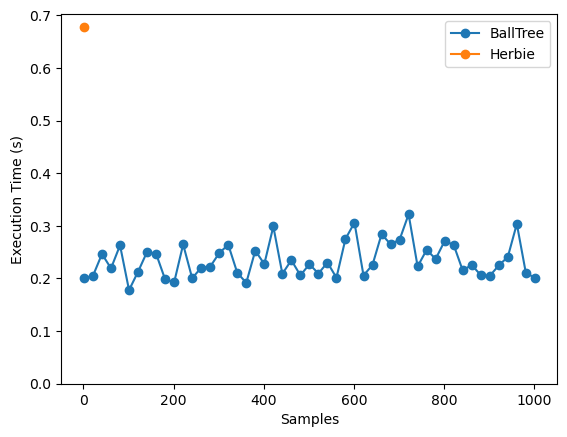

In [10]:
df_grid = ds[["latitude", "longitude"]].to_dataframe().reset_index()

times = []
samples = []
ctrl_times = []
ctrl_samples = []

for n in range(1, 1002, 20):
    points = (
        ds[["latitude", "longitude"]]
        .to_dataframe()[["latitude", "longitude"]]
        .sample(n)
        .reset_index(drop=True)
    )
    points["stid"] = [generate_random_string() for _ in range(n)]

    print(f"Testing BallTree for n={n}\tTime=", end="")
    timer = pd.Timestamp("now")
    a = nearest_neighbor(ds, points)
    times.append((pd.Timestamp("now") - timer).total_seconds())
    samples.append(n)
    print(times[-1], "seconds.")

    if n < 20:
        print(f"Testing Herbie   for n={n}\tTime=", end="")
        timer = pd.Timestamp("now")
        aa = ds.herbie.nearest_points(points)
        ctrl_times.append((pd.Timestamp("now") - timer).total_seconds())
        ctrl_samples.append(n)
        print(ctrl_times[-1], "seconds.")


plt.plot(samples, times, marker="o", label="BallTree")
plt.plot(ctrl_samples, ctrl_times, marker="o", label="Herbie")
plt.ylabel("Execution Time (s)")
plt.xlabel("Samples")
plt.ylim(ymin=0)

plt.legend()

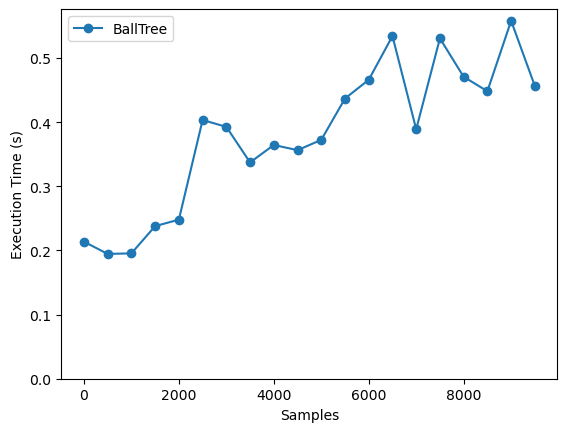

In [15]:
df_grid = ds[["latitude", "longitude"]].to_dataframe().reset_index()

times = []
samples = []

for n in range(1, 10000, 500):
    points = (
        ds[["latitude", "longitude"]]
        .to_dataframe()[["latitude", "longitude"]]
        .sample(n)
        .reset_index(drop=True)
    )
    points["stid"] = [generate_random_string() for _ in range(n)]

    timer = pd.Timestamp("now")
    a = nearest_neighbor(ds, points)
    times.append((pd.Timestamp("now") - timer).total_seconds())
    samples.append(n)


plt.plot(samples, times, marker="o", label="BallTree")
plt.ylabel("Execution Time (s)")
plt.xlabel("Samples")
plt.ylim(ymin=0)

plt.legend()

# Sample Map


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
100 100


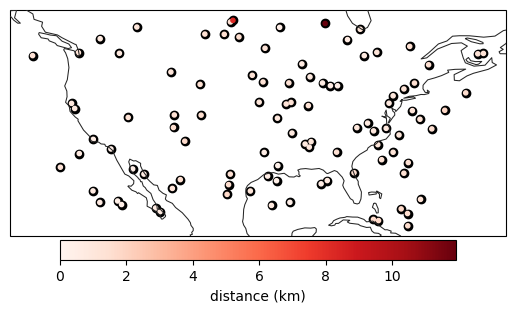

In [16]:
H = Herbie("2024-03-16 00:00", model="hrrr")
ds = H.xarray(":(?:TMP|DPT):2 m ", remove_grib=False)


ax = EasyMap().ax

n = 100
points = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points += 0.1
points["stid"] = [generate_random_string() for _ in range(n)]

a = nearest_neighbor(ds, points)

print(len(points), len(a))

# ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m)
ax.scatter(points.longitude, points.latitude, c="k", label="Requested Point")
art = ax.scatter(
    a.longitude,
    a.latitude,
    c=a.distance_grid_point,
    marker=".",
    label="Matched Grid Point",
    cmap="Reds",
    vmin=0,
)

plt.colorbar(
    art, ax=ax, label="distance (km)", orientation="horizontal", pad=0.01, shrink=0.8
)

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
100 100


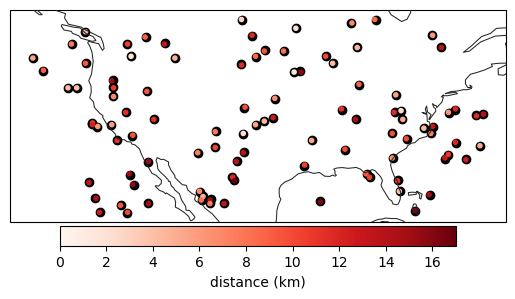

In [11]:
H_gfs = Herbie("2024-03-16 00:00", model="gfs")
ds_gfs = H_gfs.xarray(":(?:TMP|DPT):2 m ", remove_grib=False)

ax = EasyMap().ax

n = 100
points = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points["stid"] = [generate_random_string() for _ in range(n)]

a = nearest_neighbor(ds_gfs, points)

print(len(points), len(a))

# ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m)
ax.scatter(points.longitude, points.latitude, c="k", label="Requested Point")
art = ax.scatter(
    a.longitude,
    a.latitude,
    c=a.distance_grid_point,
    marker=".",
    label="Matched Grid Point",
    cmap="Reds",
    vmin=0,
)
plt.colorbar(
    art, ax=ax, label="distance (km)", orientation="horizontal", pad=0.01, shrink=0.8
)

In [7]:
a

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,38.451229,255.977623,UAgBTjmk,0.0,274.540039,272.268524,2024-03-16,0 days,2.0,38.451229,255.977623,2024-03-16
1,35.531667,274.079413,HhMueRhu,0.0,290.352539,288.081024,2024-03-16,0 days,2.0,35.531667,274.079413,2024-03-16
2,25.965581,253.770984,PRZGjeOb,0.0,283.790039,272.081024,2024-03-16,0 days,2.0,25.965581,253.770984,2024-03-16
3,32.109669,263.697565,1QUm1YJ6,0.0,291.165039,287.956024,2024-03-16,0 days,2.0,32.109669,263.697565,2024-03-16
4,35.762757,256.245898,NEgLvPkP,0.0,277.540039,274.893524,2024-03-16,0 days,2.0,35.762757,256.245898,2024-03-16
5,36.123082,258.187744,R4xuTNNa,0.0,283.352539,272.831024,2024-03-16,0 days,2.0,36.123082,258.187744,2024-03-16
6,40.718283,230.518332,ZXVv68Pc,0.0,283.915039,282.768524,2024-03-16,0 days,2.0,40.718283,230.518332,2024-03-16
7,52.035281,259.428641,IbrG4W5G,0.0,278.665039,269.643524,2024-03-16,0 days,2.0,52.035281,259.428641,2024-03-16
8,33.019500,256.885373,RTNLZZU6,0.0,281.290039,279.081024,2024-03-16,0 days,2.0,33.019500,256.885373,2024-03-16
9,38.787319,236.394934,WRbwSux1,0.0,285.977539,283.518524,2024-03-16,0 days,2.0,38.787319,236.394934,2024-03-16


# Sandbox

1. Create a DataFrame of the grid's lat/lon coordiantes in radians.
1. Create or load BallTree for model-dimensions.
1. Query requested data.


In [2]:
def time_since(t):
    return (pd.Timestamp("now") - t).total_seconds()


# NWP data
H = Herbie("2024-03-16 00:00", model="hrrr", product="sfc", fxx=0)
ds = H.xarray("(?:TMP|DPT):2 m", remove_grib=False)


replant_tree = True

# Vector of just grid's lat/lon coordinates and indices
df_grid = (
    ds[["latitude", "longitude"]]
    .drop(
        [
            coord
            for coord in ds.coords
            if not ("x" in ds[coord].dims or "y" in ds[coord].dims)
        ]
    )
    .to_dataframe()
)

# Convert lat/lon to radians for the BallTree
df_grid_radians = np.deg2rad(df_grid).rename(
    columns={"latitude": "latitude_radians", "longitude": "longitude_radians"}
)

# ======================================================================
# =======================Sample Data====================================
import random
import string


def generate_random_string(len=8):
    """Function to generate a random string."""
    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 500
points = df_grid.sample(n)[["latitude", "longitude"]].reset_index(drop=True)
points["stid"] = [generate_random_string() for _ in range(n)]
# ======================================================================

points

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-16 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,latitude,longitude,stid
0,32.227322,281.688677,On6EF5dV
1,35.019744,259.040767,Ip7LQuYz
2,34.481881,273.457950,SNyEUY8z
3,52.059332,253.967308,bQXiJPNf
4,36.647790,278.163984,lbB8CE80
...,...,...,...
495,38.324749,258.606907,xY1hQBMs
496,29.324184,265.337524,L2gDs3zR
497,37.890590,279.442086,JvDQvYOL
498,37.858233,251.947119,fGqTziAW


In [3]:
# -----------------------------
# Build or load BallTree object

# Path to the pickled BallTree objected for the model.
pkl_BallTree_file = (
    herbie.config["default"]["save_dir"]
    / "BallTree"
    / f"{ds.model}_{ds.x.size}-{ds.y.size}.pkl"
)
pkl_BallTree_file.parent.mkdir(parents=True, exist_ok=True)


if pkl_BallTree_file.exists() and not replant_tree:
    with open(pkl_BallTree_file, "rb") as f:
        tree = pickle.load(f)
else:
    # Create the BallTree tree
    timer = pd.Timestamp("now")
    tree = BallTree(
        df_grid_radians[["latitude_radians", "longitude_radians"]], metric="haversine"
    )
    print(f"Created BallTree in {time_since(timer):.2} seconds --> {pkl_BallTree_file}")

    # Save the tree object for faster loading
    with open(pkl_BallTree_file, "wb") as f:
        pickle.dump(tree, f)

Created BallTree in 2.8 seconds --> /home/blaylock/data/BallTree/hrrr_1799-1059.pkl


In [4]:
k = 2

# -------------------------------------
# Query points to find nearest neighbor
# The queries lat/lon points need to be in Radians
# TODO: Add option to use MultiProcessing here, to split the Dataset into chunks
dist, ind = tree.query(
    np.deg2rad(points[["latitude", "longitude"]]),
    k=k,
)
np.shape(dist), np.shape(ind)

((500, 2), (500, 2))

In [5]:
k_points = []
for i in range(k):
    x = points.copy()
    x["distance_grid"] = dist[:, i] * 6371  # Multiply by radius of the earth (km)
    x["index_grid"] = ind[:, i]

    x = pd.concat(
        [
            x,
            df_grid.reset_index()
            .iloc[x["index_grid"]]
            .add_suffix("_grid")
            .reset_index(drop=True),
        ],
        axis=1,
    )

    k_points.append(x)
k_points[0]

,latitude,longitude,stid,distance_grid,index_grid,y_grid,x_grid,latitude_grid,longitude_grid
0,32.227322,281.688677,On6EF5dV,0.0,647341,359,1500,32.227322,281.688677
1,35.019744,259.040767,Ip7LQuYz,0.0,723992,402,794,35.019744,259.040767
2,34.481881,273.457950,SNyEUY8z,0.0,720834,400,1234,34.481881,273.457950
3,52.059332,253.967308,bQXiJPNf,0.0,1882453,1046,699,52.059332,253.967308
4,36.647790,278.163984,lbB8CE80,0.0,900863,500,1363,36.647790,278.163984
...,...,...,...,...,...,...,...,...,...
495,38.324749,258.606907,xY1hQBMs,0.0,945261,525,786,38.324749,258.606907
496,29.324184,265.337524,L2gDs3zR,0.0,341003,189,992,29.324184,265.337524
497,37.890590,279.442086,JvDQvYOL,0.0,994440,552,1392,37.890590,279.442086
498,37.858233,251.947119,fGqTziAW,0.0,941468,523,591,37.858233,251.947119


In [42]:
# https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing
matches = (
    ds[[i for i in ds if ds[i].dims != ()]]
    .sel(x=k_points[0].x_grid.to_xarray(), y=k_points[0].y_grid.to_xarray())
    .to_pandas()
)
matches

,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
index,,,,,,,,
0,296.790039,294.143524,2024-03-16,0 days,2.0,32.227322,281.688677,2024-03-16
1,285.415039,276.706024,2024-03-16,0 days,2.0,35.019744,259.040767,2024-03-16
2,290.852539,287.581024,2024-03-16,0 days,2.0,34.481881,273.457950,2024-03-16
3,273.665039,271.143524,2024-03-16,0 days,2.0,52.059332,253.967308,2024-03-16
4,288.540039,286.706024,2024-03-16,0 days,2.0,36.647790,278.163984,2024-03-16
...,...,...,...,...,...,...,...,...
495,283.602539,271.706024,2024-03-16,0 days,2.0,38.324749,258.606907,2024-03-16
496,292.665039,292.206024,2024-03-16,0 days,2.0,29.324184,265.337524,2024-03-16
497,285.727539,284.581024,2024-03-16,0 days,2.0,37.890590,279.442086,2024-03-16


In [47]:
result = pd.concat(
    [
        k_points[0]
        .drop(
            columns=[
                "index_grid",
                "y_grid",
                "x_grid",
                "latitude_grid",
                "longitude_grid",
            ]
        )
        .add_suffix("_point"),
        matches,
    ],
    axis=1,
)
result

,latitude_point,longitude_point,stid_point,distance_grid_point,t2m,d2m,time,step,heightAboveGround,latitude,longitude,valid_time
0,32.227322,281.688677,On6EF5dV,0.0,296.790039,294.143524,2024-03-16,0 days,2.0,32.227322,281.688677,2024-03-16
1,35.019744,259.040767,Ip7LQuYz,0.0,285.415039,276.706024,2024-03-16,0 days,2.0,35.019744,259.040767,2024-03-16
2,34.481881,273.457950,SNyEUY8z,0.0,290.852539,287.581024,2024-03-16,0 days,2.0,34.481881,273.457950,2024-03-16
3,52.059332,253.967308,bQXiJPNf,0.0,273.665039,271.143524,2024-03-16,0 days,2.0,52.059332,253.967308,2024-03-16
4,36.647790,278.163984,lbB8CE80,0.0,288.540039,286.706024,2024-03-16,0 days,2.0,36.647790,278.163984,2024-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...
495,38.324749,258.606907,xY1hQBMs,0.0,283.602539,271.706024,2024-03-16,0 days,2.0,38.324749,258.606907,2024-03-16
496,29.324184,265.337524,L2gDs3zR,0.0,292.665039,292.206024,2024-03-16,0 days,2.0,29.324184,265.337524,2024-03-16
497,37.890590,279.442086,JvDQvYOL,0.0,285.727539,284.581024,2024-03-16,0 days,2.0,37.890590,279.442086,2024-03-16
498,37.858233,251.947119,fGqTziAW,0.0,270.290039,266.706024,2024-03-16,0 days,2.0,37.858233,251.947119,2024-03-16


In [33]:
pd.DataFrame(ds["latitude"].values)

AttributeError: 'RangeIndex' object has no attribute '_format_flat'

         0
0    90.00
1    89.75
2    89.50
3    89.25
4    89.00
..     ...
716 -89.00
717 -89.25
718 -89.50
719 -89.75
720 -90.00

[721 rows x 1 columns]

In [38]:
pd.DataFrame({"latitude": [1, 2, 3]}, index=[0, 1, 2])

AttributeError: 'Index' object has no attribute '_format_flat'

   latitude
0         1
1         2
2         3

In [6]:
(
    ds[["latitude", "longitude"]]
    .drop([i for i, j in ds.coords.items() if not j.ndim])
    .to_dataframe(None)
)

latitude   longitude
y    x                          
0    0     21.138123  237.280472
     1     21.145110  237.307139
     2     21.152090  237.333810
     3     21.159063  237.360485
     4     21.166029  237.387165
...              ...         ...
1058 1794  47.883306  298.936520
     1795  47.873043  298.973110
     1796  47.862771  299.009688
     1797  47.852488  299.046254
     1798  47.842195  299.082807

[1905141 rows x 2 columns]

In [7]:
ds_gfs.rename_dims({"latitude": "y", "longitude": "x"})

<xarray.Dataset> Size: 8MB
Dimensions:              (y: 721, x: 1440)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-16
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
  * latitude             (y) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude            (x) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time           datetime64[ns] 8B 2024-03-16
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 4MB ...
    d2m                  (y, x) float32 4MB ...
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gfs
    product:                 pgrb2.0p25
    description:             Global Forecast System
    remote_grib:             https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20...
    local_grib:              /home/blaylock/data/gfs/20240316/subset_44efcb50...
    searchString:            :(?:TMP|DPT):2 m

In [8]:
ds1 = ds_gfs.rename_dims({"latitude": "y", "longitude": "x"})

df_grid = (
    ds1[["latitude", "longitude"]]
    .drop([i for i, j in ds1.coords.items() if not j.ndim])
    .to_dataframe(None)
)


df_grid

latitude  longitude
y   x                        
0   0         90.0       0.00
    1         90.0       0.25
    2         90.0       0.50
    3         90.0       0.75
    4         90.0       1.00
...            ...        ...
720 1435     -90.0     358.75
    1436     -90.0     359.00
    1437     -90.0     359.25
    1438     -90.0     359.50
    1439     -90.0     359.75

[1038240 rows x 2 columns]